# Finite Differences for Helmholtz/Poisson-Problem
The *Finite Difference Method* (FDM) is a numerical method to solve *Partial Differential Equations* (PDEs) approximately.
## Poisson Problem
We want to solve the Poisson equation
$$
\begin{aligned}
  -Δ u(x,y) &= f(x,y), & (x,y) &∈ [0,L]^2 \\
  u(x,0) &= b(x), & x &∈ [0,L] \\
  u(x,L) &= t(x), & x &∈ [0,L] \\
  u(L,y) &= r(y), & y &∈ [0,L] \\
  u(0,y) &= l(y), & y &∈ [0,L] \\
\end{aligned}
$$
on a unit-suqare with $L=1$. The domain is discreitize uniformly with N grid-points per dimensions leading to $h=\frac{1}{N-1}$. We discreitze the Laplacian using central finite differences with second order as
$$
    Δ u(x,y) = \frac{-u(x+h,y) - u(x-h,y) + 4u(x,y) - u(x,y+h) - u(x,y-h)}{h^2} + \mathcal{O}(h^2) \\
$$
such that the stencil for node values reads
$$
\begin{aligned}
    u_{i,j} &≈ \frac{-u_{i+1,j} - u_{i-1,j} + 4u_{i,j} -u_{i,j+1} -u_{i,j-1}}{h^2}
    \\ ⇔
    [- Δu_h]_ξ &=
    \frac{1}{h^2}
    \begin{bmatrix}
         0 & -1 &  0 \\
        -1 &  4 & -1 \\
         0 & -1 &  0 \\
    \end{bmatrix}
    , \quad ξ ∈ Ω_h
\end{aligned}
$$


In [1]:
using LinearAlgebra
using SparseArrays
using Plots


## Domain and Boundary Conditions
The domain $\bar{Ω}$ $[0,L]^2$ is split into the nodes $\{(x_i,y_j)\}_{i,j=0 \dots N} ∈\bar{Ω}_h$ with
$$
    x_i = \frac{L}{N-1} ,\quad y_j = \frac{L}{N-1}
$$
The interior nodes are $\{(x_i,y_j)\}_{i,j=1 \dots N-1} ∈ Ω_h$.
We further need boundary conditions for all four sides of the unit square.


In [2]:
struct UnitSquare
    N::Int64
    h::Float64
    xh::Array{Float64,1}
    yh::Array{Float64,1}
    function UnitSquare(N)
        h = 1/(N-1)
        xh = range(0, 1, step=h)
        yh = range(0, 1, step=h)
        N = new(N, h, xh, yh)
    end
end

struct UnitSquareBCs
    bot
    right
    top
    left
end


## Discretization of Poisson Problem
### TODO
- Explain Matrix structure and RHS
- Define Kronecker product and Kronecker sum


In [3]:
function Δₕ(Ω::UnitSquare)
    ⊗ = kron
    dxx = spdiagm(-1=>ones(Ω.N-3), 0=>-2ones(Ω.N-2), 1=>ones(Ω.N-3))
    dyy = spdiagm(-1=>ones(Ω.N-3), 0=>-2ones(Ω.N-2), 1=>ones(Ω.N-3))
    return 1/Ω.h^2 * (I(Ω.N-2) ⊗ dxx + dyy ⊗ I(Ω.N-2))
end

function bₕ(Ω::UnitSquare, f, bcs::UnitSquareBCs)
    N = Ω.N
    xInt = Ω.xh[2:end-1]
    yInt = Ω.yh[2:end-1]

    fh = vec(f.(xInt,yInt'))
    bh = 1/Ω.h^2 .* vec(bcs.bot.(xInt))
    rh = 1/Ω.h^2 .* vec(bcs.right.(yInt))
    th = 1/Ω.h^2 .* vec(bcs.top.(xInt))
    lh = 1/Ω.h^2 .* vec(bcs.left.(yInt))

    bvec = zeros((N-2)^2)
    bvec += fh
    bvec[1               : 1     : N-2] += bh
    bvec[(N-2)*(N-2-1)+1 : 1     : end] += th
    bvec[(N-2)           : (N-2) : end] += rh
    bvec[1               : (N-2) : end] += lh

    return bvec
end

function solvePoisson(Ω::UnitSquare, f, bcs::UnitSquareBCs)
    A = -Δₕ(Ω)
    b = bₕ(Ω, f, bcs)
    return (A) \ b
end

function plotSol(Ω::UnitSquare, u, bcs::UnitSquareBCs, edgeAvg=true)
    pyplot()
    N = Ω.N
    uMat = zeros(N,N)
    uMat[2:end-1,2:end-1] = reshape(u, (N-2, N-2))
    uMat[2:N-1,1] = vec(bcs.bot.(Ω.xh[2:end-1]))
    uMat[2:N-1,N] = vec(bcs.top.(Ω.xh[2:end-1]))
    uMat[N,2:N-1] = vec(bcs.right.(Ω.yh[2:end-1]))
    uMat[1,2:N-1] = vec(bcs.left.(Ω.yh[2:end-1]))
    if edgeAvg
        uMat[1,1] = 0.5 * (uMat[1,2] + uMat[2,1])
        uMat[1,N] = 0.5 * (uMat[1,N-1] + uMat[2,N])
        uMat[N,1] = 0.5 * (uMat[N-1,1] + uMat[N,2])
        uMat[N,N] = 0.5 * (uMat[N-1,N] + uMat[N-1,N])
    else
        uMat[1,1] = uMat[1,N] = uMat[N,1] = uMat[N,N] = 0
    end
    Plots.surface(Ω.xh, Ω.yh, uMat', camera=(35, 35), title="Discrete Solution")
end


plotSol (generic function with 2 methods)

## Experiments
- Show a solution with inhomogenous boundary conditions and source
- Discuss maximum principle (no source!)


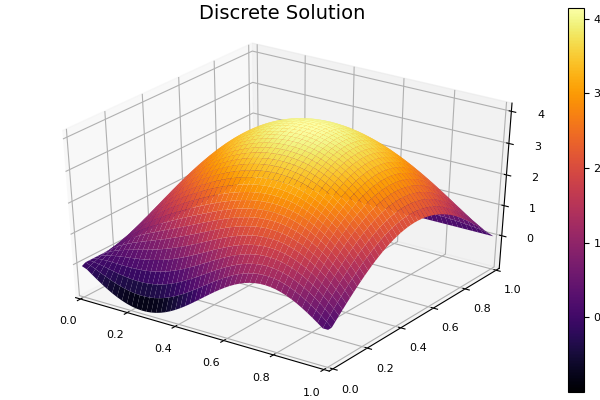

In [4]:
Ω = UnitSquare(50)
bcs = UnitSquareBCs(x -> -sin(2pi*x), y -> 2sin(pi*y), x -> 0, y -> 0)
f(x,y) = 50
u = solvePoisson(Ω, f, bcs)
plotSol(Ω, u, bcs)


## Conditioning of System Matrix
We know from the lecture that
$$
    κ_2(A) = \frac{λ_{\max}}{λ_{\min}} = \frac{2}{π h^2} (1 + \mathcal{O}(h^2))
$$
We observe this numerically.


0.33333 3.00000
0.14286 19.19567
0.06667 90.52313
0.03226 388.81213


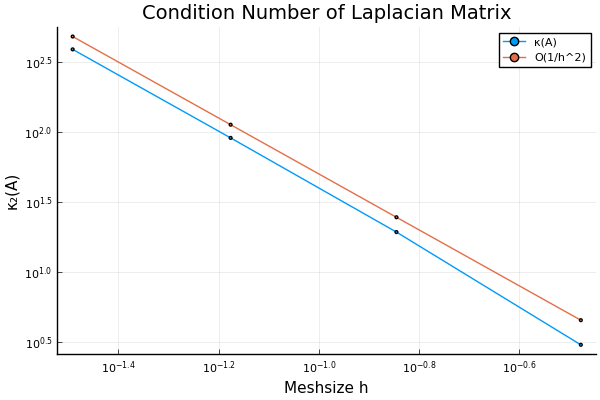

In [5]:
using Printf
condArray = Vector{Float64}()
hArray = Vector{Float64}()
for exp = 2:5
    N = 2^exp
    Ω = UnitSquare(2^exp)
    A = Array(Δₕ(Ω))
    condNum = cond(A)
    h = Ω.h
    @printf "%.5f %.5f\n" h condNum
    append!(condArray, condNum)
    append!(hArray, h)
end
plot(
    hArray, [condArray, 0.5 ./(hArray.^2)],
    xaxis=("Meshsize h", :log), yaxis=("κ₂(A)", :log), label=["κ(A)" "O(1/h^2)"], marker = (:circle, 2),
    title="Condition Number of Laplacian Matrix"
)


## Helmholtz Problem
- Derivation comes from the Wave equation, details in the lecture
- Important in Physics: Electromagnetic waves?

We now quickly consider the Helmholtz problem (positive Laplace plus identity term) as
$$
\begin{aligned}
  Δ u(x,y) + k^2 u(x,y) &= f(x,y), & (x,y) &∈ [0,L]^2 \\
  u(x,0) &= b(x), & x &∈ [0,L] \\
  u(x,L) &= t(x), & x &∈ [0,L] \\
  u(L,y) &= r(y), & y &∈ [0,L] \\
  u(0,y) &= l(y), & y &∈ [0,L] \\
\end{aligned}
$$
with the wavenumber $k$. The discretization is similar to the Poisson problem. We again use 2nd-order central differences and add an diagonal term $k^2$. The resulting stencil reads
$$
  [Δu_h]_ξ + k^2 [I_h]_ξ =
  \begin{bmatrix}
    0 &        1 & 0 \\
    1 & -4 + k^2 & 1 \\
    0 &        1 & 0 \\
  \end{bmatrix}
$$


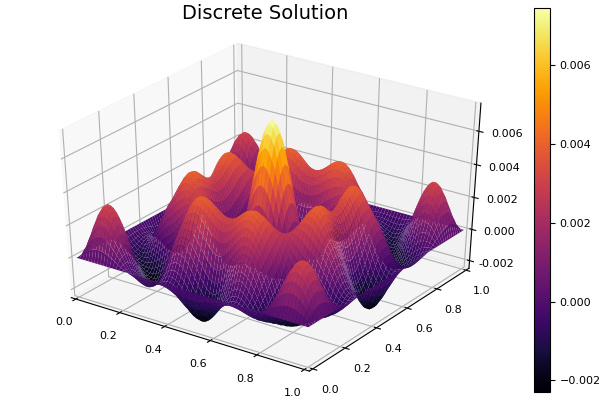

In [6]:
function solveHelmholtz(Ω::UnitSquare, f, k::Number, bcs::UnitSquareBCs)
    A = Δₕ(Ω) + k^2 * I((Ω.N-2)^2)
    b = bₕ(Ω, f, bcs)
    return (A) \ b
end
Ω = UnitSquare(75)
bcsHelm = UnitSquareBCs(x -> 0, y -> 0, x -> 0, y -> 0)
f(x,y) = sqrt((x-0.5)^2+(y-0.5)^2) < 0.37 ? 1 : 0
u = solveHelmholtz(Ω, f, 25, bcsHelm)
plotSol(Ω, u, bcsHelm)